In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 
import torch
import cv2 
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

from Trainer import train_model
from Dataloader import JetcarDataset, SimulatorDataset 
from Models import NetworkNvidia, ResNet18, ResNet34, AlexNet, VGG16

In [69]:
transforms = torch.nn.Sequential(
    T.RandomResizedCrop(size=(224, 224),scale=(0.9,1)),
    T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 4)),
    T.ColorJitter(brightness=.3, hue=.3, saturation=.3),
    #T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
) 

In [70]:
realData = JetcarDataset("data_mix/data.csv", "data_mix/img/", transform=transforms)
x,y = realData[0]
print(x.shape)
print(y)

(3, 224, 224)
[0.22678304 0.6598407 ]


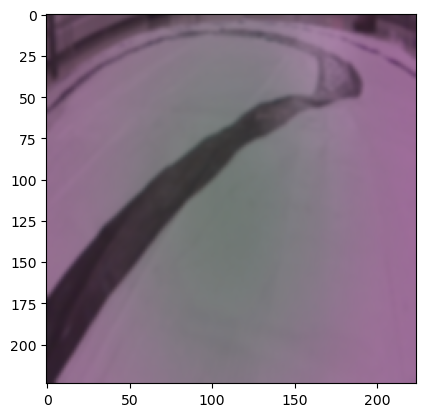

In [81]:
img, label = realData.get_rgb(240)
plt.imshow(img)

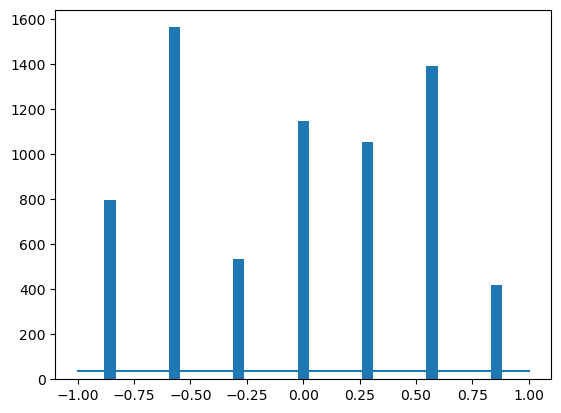

In [82]:
realData.plot_hist()

In [83]:
realData.__len__()

6907

In [7]:
train_generator = DataLoader(realData, batch_size=8, shuffle=True, num_workers=4)

In [8]:
x,y = next(iter(train_generator))

In [9]:
x.shape

torch.Size([8, 3, 224, 224])

In [3]:
model = NetworkNvidia()
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

2959430


In [19]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9) 
# optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [20]:
device = torch.device("mps")

In [21]:
net, train_loss = train_model(50,model,train_generator,criterion,optimizer, device=device)

Test loss decreased (inf --> 0.015995. Saving model...
Epoch: 1/50 	Train Loss: 0.015995 	Epoch Time:30.450674
Test loss decreased (0.015995 --> 0.015246. Saving model...
Epoch: 2/50 	Train Loss: 0.015246 	Epoch Time:30.363479
Test loss decreased (0.015246 --> 0.015219. Saving model...
Epoch: 3/50 	Train Loss: 0.015219 	Epoch Time:30.318441
Epoch: 4/50 	Train Loss: 0.015241 	Epoch Time:30.590624
Test loss decreased (0.015219 --> 0.015177. Saving model...
Epoch: 5/50 	Train Loss: 0.015177 	Epoch Time:30.090188
Epoch: 6/50 	Train Loss: 0.015182 	Epoch Time:30.323125
Test loss decreased (0.015177 --> 0.015131. Saving model...
Epoch: 7/50 	Train Loss: 0.015131 	Epoch Time:30.424531
Test loss decreased (0.015131 --> 0.014908. Saving model...
Epoch: 8/50 	Train Loss: 0.014908 	Epoch Time:30.234928
Test loss decreased (0.014908 --> 0.012429. Saving model...
Epoch: 9/50 	Train Loss: 0.012429 	Epoch Time:30.558776
Test loss decreased (0.012429 --> 0.011090. Saving model...
Epoch: 10/50 	Train L

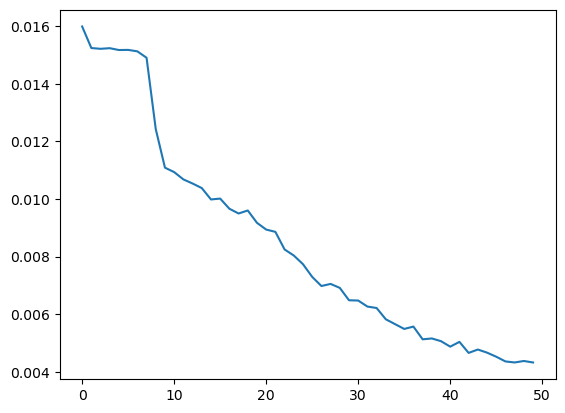

In [22]:
plt.plot(train_loss) 

In [23]:
x,y = next(iter(train_generator))
out = model(x.to(device))
print(out)

tensor([[-0.4939,  0.6403],
        [-0.4015,  0.6297],
        [-0.2420,  0.5832],
        [ 0.4513,  0.6141],
        [ 0.4602,  0.5855],
        [ 0.4417,  0.6027],
        [-0.0929,  0.7594],
        [ 0.3517,  0.6223]], device='mps:0', grad_fn=<LinearBackward0>)


/opt/homebrew/Caskroom/miniforge/base/envs/jetracer_mac/lib/python3.8/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


In [24]:
out[0]

tensor([-0.4939,  0.6403], device='mps:0', grad_fn=<SelectBackward0>)

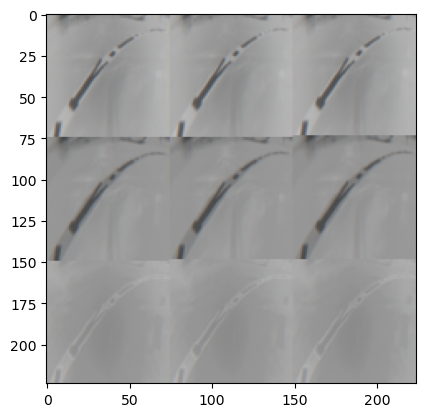

In [25]:
plt.imshow(np.array(x[7].reshape(224,224,3)))

In [85]:
x,y = next(iter(train_generator))
out = model(x.to(device))
print(out)

tensor([[-0.1045,  0.2120],
        [-0.1014,  0.2239],
        [-0.5670,  0.2515],
        [-0.2095,  0.2164]], device='mps:0', grad_fn=<LinearBackward0>)


In [86]:
y

tensor([[ 0.4330,  0.2165],
        [ 0.0618,  0.2165],
        [-1.0000,  0.2371],
        [-0.8660,  0.1753]])

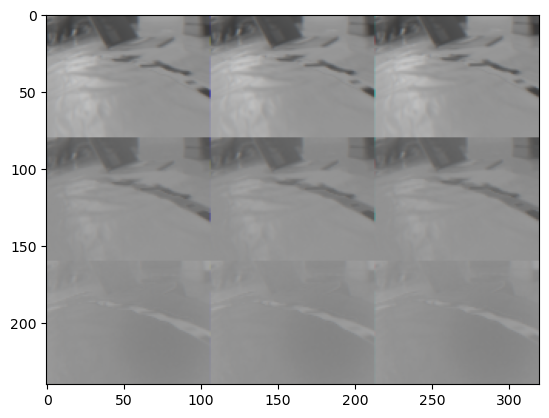

In [91]:
plt.imshow(np.array(x[2].reshape(240,320,3)))

In [99]:
x.max()

tensor(1.)